In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

np.random.seed(42)

# Next steps
- ~~Calibrate basic elo model to true probabilities~~
- ~~Factor-in home field advantage to elo model~~
  - Did not work 
- Increase the relative influence of early-season games on elo score
- Determine a way to consider goals for/against
- Consider the inclusion of additional features, e.g., offensive/defensive efficiency, possession, pace, etc.
- Consider more powerful models
- Consider the results of recent games
- Consider Bayesian approach
- Consider logistics such as game timing, time since last game, distance from home field
- Below: Bayesian extension to ELO
- https://www.degruyter.com/document/doi/10.1515/jqas-2020-0066/html?casa_token=8Ei5tYyU1_0AAAAA:UrwD-uhfx0gg4u0s-gqXdz1OvVtB47aA6Z-1RnwkrQbji9jetjl34Ed32NJjbbRVDIL-y963-na6NQ
- Below: Glicko Paper
- http://www.glicko.net/research/glicko.pdf
- Below: Bradley-Terry model (Wikipedia)- seems like it may be relevant to ranking algorithms and match prediction
- https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model
- m2dc
- Consider Bayesian approach different from Glicko in which updates have theoretical basis other than Bradley-Terry model (e.g., forming performance distributions via a collection of points, a new point is added according to the mean performance given a game outcome)
  - Can derive a model using the known result for E(Y|Y-X>0) for two normal RVs X and Y. Can add a point at this expectation (or the one for X) when a team wins/loses. However, there would be some problems using this.
    - If a team wins against a much worse team, one must determine the extent to which the new point contributes to the posterior performance distribution.
    - May need to do a posterior update considering uncertainty in the performance standard deviation via inverse Wishart distribution.
  - A Bradley-Terry model may actually work better as it just makes the assumption that team performance is logistically distributed, which seems fair enough. Also offers highly tractable and interpretable outcome probabilities according to each team's rating.

In [2]:
games = pd.read_csv("games_2011_to_2023.csv", parse_dates=["date"])
wins = games.loc[games.result == "W"]
schools = pd.read_csv(
    "general_data/schools.csv",
    skiprows=1,
    header=None,
    names=["school_id", "school_name"],
).set_index("school_id")

In [95]:
class ELO:
    def __init__(
        self,
        winners,
        losers,
        ids=None,
        timestamps=None,
        k=20,
        elo_init=1500,
        elo_diff=400,
        seasonal_mean_reversion=0,
    ):
        self.k = k
        self.elo_init = elo_init
        self.elo_diff = elo_diff

        winners = list(winners)
        losers = list(losers)

        ELO.__check_valid_games__(winners, losers, ids, timestamps)
        ELO.__check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion)

        # Assemble temporary empty dataframe to store ELOs
        if ids is None:
            self.ids = range(len(winners))
        else:
            self.ids = ids
        self.winners = winners
        self.losers = losers
        self.competitors = sorted(list(set(winners) | set(losers)))
        self.timestamps = timestamps
        self.seasonal_mean_reversion = seasonal_mean_reversion
        if self.timestamps is not None:
            # sort arrays by timestamp
            self.ids, self.winners, self.losers, self.timestamps = zip(
                *sorted(
                    zip(self.ids, self.winners, self.losers, self.timestamps),
                    key=lambda x: x[3],
                )
            )

    # Compute the ELO of every competitor after each match (37s original)
    # 0.04476022720336914s (without dataframe conversion)
    # 0.15063881874084473 (with dataframe conversion)
    def fit_fastest(self):
        start = time.time()
        elo_dict = OrderedDict(
            [(competitor, self.elo_init) for competitor in self.competitors]
        )
        game_array = np.vstack([self.ids, self.winners, self.losers, self.timestamps]).T
        elo_array = [np.ones(len(self.competitors)) * self.elo_init]
        game_probs, winner_prev_elo, loser_prev_elo = [], [], []
        current_year = self.timestamps[0].year if self.timestamps is not None else None
        for i, game in enumerate(game_array):
            game_id, winner, loser, timestamp = game
            if self.timestamps is not None and timestamp.year != current_year:
                current_year = timestamp.year
                mean_elo = np.mean(elo_array[-1])
                elo_dict = {
                    team: mean_elo
                    + (1 - self.seasonal_mean_reversion) * (elo - mean_elo)
                    for team, elo in elo_dict.items()
                }
            winner_elo, loser_elo = elo_dict[winner], elo_dict[loser]
            winner_new_elo, loser_new_elo, expected_outcome_prob = (
                ELO.compute_pairwise_elo(
                    winner_elo, loser_elo, elo_diff=self.elo_diff, k=self.k
                )
            )
            game_probs.append(expected_outcome_prob)
            elo_dict[winner], elo_dict[loser] = winner_new_elo, loser_new_elo
            elo_array.append(list(elo_dict.values()))
        self.elo_df = pd.concat(
            [
                pd.DataFrame(
                    np.vstack(
                        [
                            self.ids,
                            self.timestamps,
                            self.winners,
                            self.losers,
                            game_probs,
                        ]
                    ).T,
                    columns=["id", "timestamp", "winner", "loser", "win_prob"],
                ).set_index("id"),
                pd.DataFrame(elo_array[1:], columns=self.competitors, index=self.ids),
            ],
            axis=1,
        )
        print("Computed elos in", time.time() - start, "seconds.")

    # Show a calibration curve of the ELO output probabilities after fitting
    def show_calibration(self, start_year=2018, A=5, B=0.2):
        d = self.elo_df.loc[self.elo_df.timestamp > str(start_year)]
        win_sample = d.sample(frac=0.5)
        lose_sample = d.drop(win_sample.index)
        p_true = [1] * len(win_sample) + [0] * len(lose_sample)
        p_pred = win_sample.win_prob.tolist() + (1 - lose_sample.win_prob).tolist()
        p_pred = np.array(p_pred)

        def sigmoid(x, A, B):
            return 1 / (1 + np.exp(A * x + B))

        def invsigmoid(x, A, B=1 / 2):
            return -(1 / A) * np.log((1 + B) / (x + B / 2) - 1) + 1 / 2

        prob_true, prob_pred = calibration_curve(
            p_true, invsigmoid(p_pred, A, B), n_bins=20, strategy="uniform"
        )
        # prob_true, prob_pred = calibration_curve(p_true, p_pred, n_bins=20, strategy='uniform')
        plt.figure(dpi=300)
        CalibrationDisplay(prob_true, prob_pred, p_pred).plot()
        plt.suptitle("Calibration Curve with Inverse Sigmoid")
        plt.title(
            f"A={A}, B={B}, start_year={start_year}, k={self.k}, elo_init={self.elo_init}, elo_diff={self.elo_diff}, smr={self.seasonal_mean_reversion}"
        )
        plt.grid()

    @staticmethod
    def compute_pairwise_elo(winner_elo, loser_elo, elo_diff, k):
        expected_outcome_prob = ELO.compute_expected_outcome_prob(
            winner_elo, loser_elo, elo_diff=elo_diff
        )
        return (
            winner_elo + k * (1 - expected_outcome_prob),
            loser_elo - k * (1 - expected_outcome_prob),
            expected_outcome_prob,
        )

    @staticmethod
    def compute_expected_outcome_prob(elo1, elo2, elo_diff=400):
        return 1 / (1 + 10 ** ((elo2 - elo1) / elo_diff))

    @staticmethod
    def __check_valid_params__(k, elo_init, elo_diff, seasonal_mean_reversion):
        assert isinstance(k, int) and k > 0
        assert isinstance(elo_init, int) and elo_init > 0
        assert isinstance(elo_diff, int) and elo_diff > 0
        assert (
            isinstance(seasonal_mean_reversion, float) and seasonal_mean_reversion <= 1
        )

    @staticmethod
    def __check_valid_games__(winners, losers, ids, timestamps):
        # assert proper data types
        assert pd.api.types.is_list_like(winners)
        assert pd.api.types.is_list_like(losers)
        assert ids is None or pd.api.types.is_list_like(ids)
        assert timestamps is None or pd.api.types.is_list_like(timestamps)

        # check that winners, losers, ids, and timestamps have the same length
        assert len(winners) == len(losers)
        assert ids is None or len(ids) == len(winners)
        assert timestamps is None or len(timestamps) == len(winners)

        # check that all ids are unique
        assert ids is None or len(set(ids)) == len(ids)

        # check that no teams play against themselves
        for i in range(len(winners)):
            assert winners[i] != losers[i]

        # check that the timestamps are valid
        if timestamps is not None:
            for timestamp in timestamps:
                try:
                    pd.to_datetime(timestamp)
                except ValueError:
                    raise ValueError("Invalid timestamp: {}".format(timestamp))

    def show_elos(self):
        return self.elo_df

In [94]:
if not None:
    print("hi")

hi


In [4]:
elo_df = (
    wins[["date", "contest_id", "site", "school_id", "opponent_school_id"]]
    .sort_values(by="date")
    .set_index("date")
)
elo_df.columns = ["id", "site", "winner", "loser"]

In [5]:
home_win_pct = (
    games.loc[games.site == "home"].result.value_counts()["W"]
    / games.loc[games.site == "home"].shape[0]
)

In [6]:
def compute_home_elo_advantage(home_win_pct, elo_diff=400):
    return -elo_diff * np.log10(1 / home_win_pct - 1)

In [7]:
compute_home_elo_advantage(0.57)

48.96256003716192

Computed elos in 0.11167287826538086 seconds.


<Figure size 1920x1440 with 0 Axes>

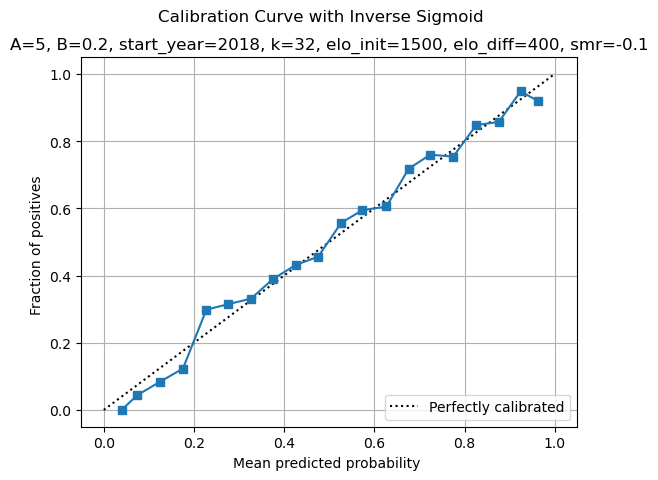

In [90]:
sd = ELO(
    elo_df.winner,
    elo_df.loser,
    ids=elo_df.id,
    timestamps=elo_df.index,
    seasonal_mean_reversion=-0.1,
    k=32,
    elo_diff=400,
)
sd.fit_fastest()
sd.show_calibration()

Computed elos in 0.1984422206878662 seconds.
0.7520420070011669


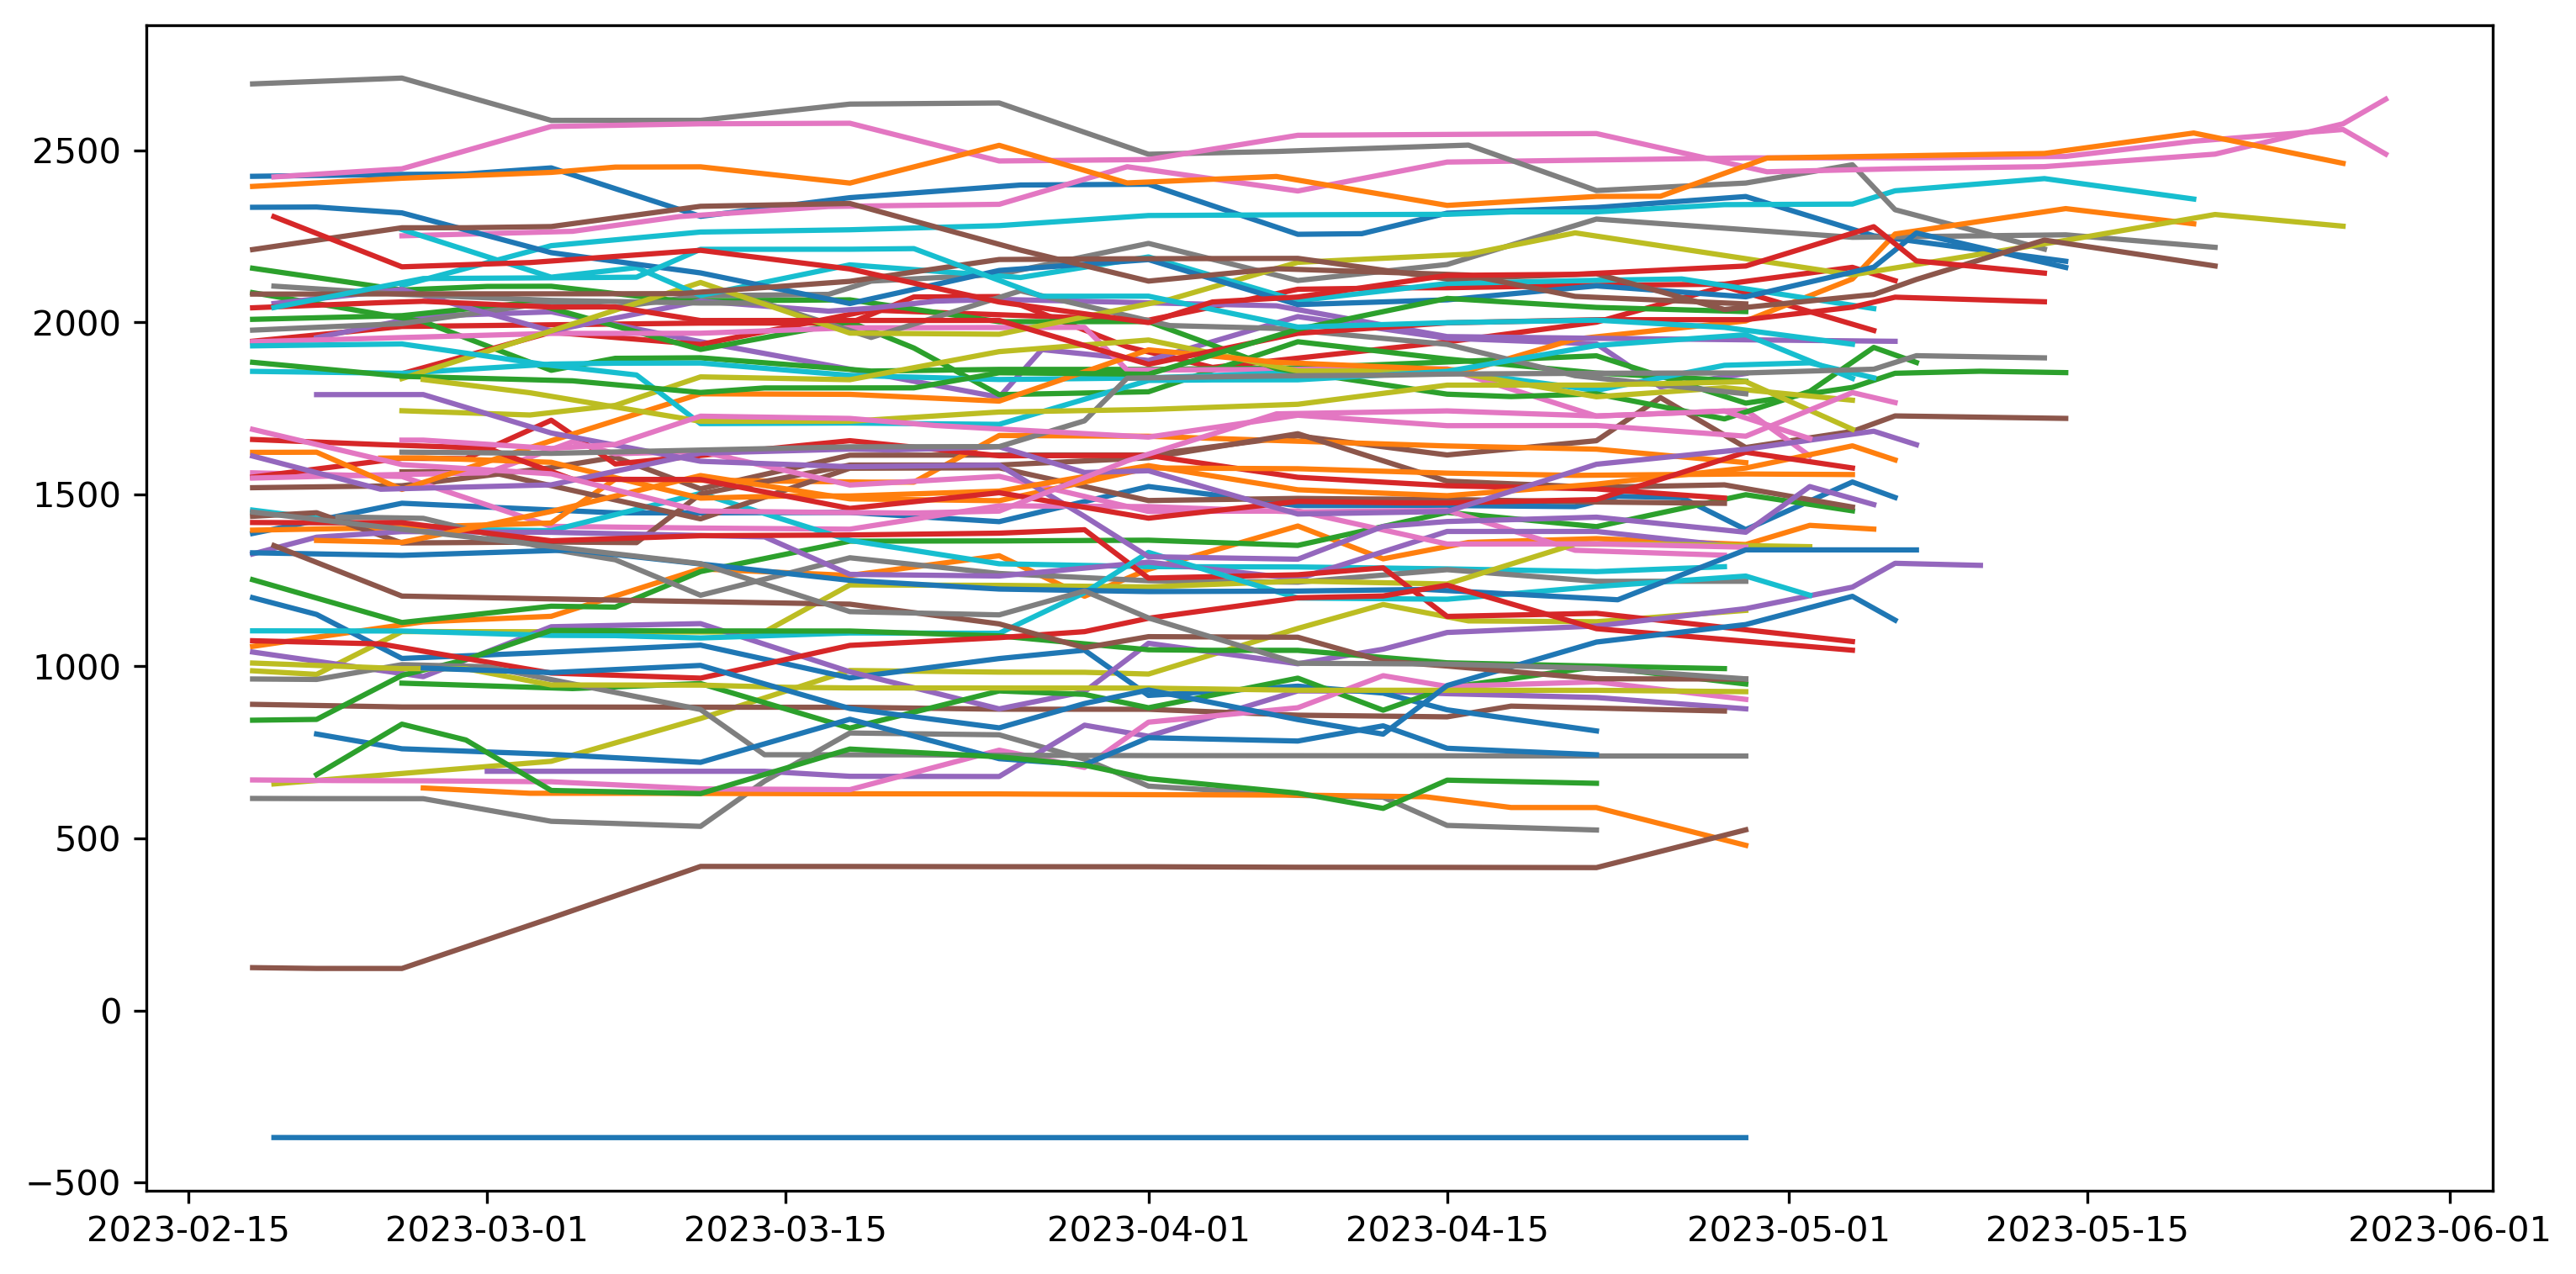

In [ ]:
# for smr in np.arange(0, 1.1, 0.1):
sd = ELO(
    elo_df.winner,
    elo_df.loser,
    ids=elo_df.id,
    timestamps=elo_df.index,
    seasonal_mean_reversion=-0.1,
    k=150,
)
sd.fit_fastest()
d = sd.show_elos()
plt.figure(dpi=300, figsize=(12, 6))
for school in sd.competitors:
    plt.plot(
        d.iloc[-500:].loc[(d.winner == school) | (d.loser == school)].timestamp,
        d.iloc[-500:].loc[(d.winner == school) | (d.loser == school)][school],
        label=schools.loc[school].school_name,
    )
print(
    (d.loc[d.timestamp > "2020"].win_prob > 0.5).sum()
    / len(d.loc[d.timestamp > "2020"])
)

In [ ]:
accs = {}
for k in range(50, 325, 25):
    for elo_diff in range(400, 401, 200):
        for smr in np.arange(-0.3, 0.3, 0.1):
            e = ELO(
                elo_df.winner,
                elo_df.loser,
                ids=elo_df.id,
                timestamps=elo_df.index,
                k=k,
                elo_diff=elo_diff,
                seasonal_mean_reversion=smr,
            )
            e.fit_fastest()
            df = e.show_elos()
            nf = df.rename(
                columns={
                    school: schools.loc[school].school_name for school in df.columns[4:]
                }
            )
            accs[(k, elo_diff, smr)] = (
                nf.loc[nf.timestamp > "2020"].win_prob > 0.5
            ).sum() / len(nf.loc[nf.timestamp > "2020"])

Computed elos in 0.1861283779144287 seconds.
Computed elos in 0.17492985725402832 seconds.
Computed elos in 0.2580554485321045 seconds.
Computed elos in 0.2576866149902344 seconds.
Computed elos in 0.30701375007629395 seconds.
Computed elos in 0.2274456024169922 seconds.
Computed elos in 0.19362282752990723 seconds.
Computed elos in 0.16492629051208496 seconds.
Computed elos in 0.177565336227417 seconds.
Computed elos in 0.1261758804321289 seconds.
Computed elos in 0.12525558471679688 seconds.
Computed elos in 0.11408352851867676 seconds.
Computed elos in 0.12037491798400879 seconds.
Computed elos in 0.11997866630554199 seconds.
Computed elos in 0.11745357513427734 seconds.
Computed elos in 0.10951852798461914 seconds.
Computed elos in 0.11017322540283203 seconds.
Computed elos in 0.11076569557189941 seconds.
Computed elos in 0.1603834629058838 seconds.
Computed elos in 0.10669636726379395 seconds.
Computed elos in 0.10833358764648438 seconds.
Computed elos in 0.10433650016784668 secon

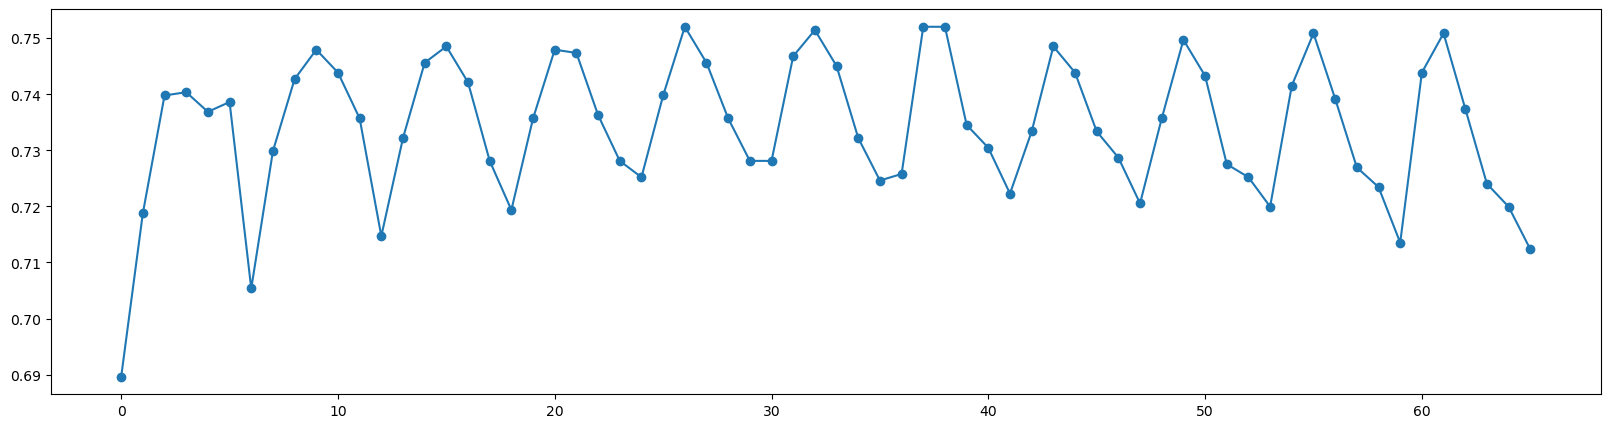

In [ ]:
ac = list(accs.values())
plt.figure(figsize=(20, 5))
plt.plot(ac, marker="o")

In [ ]:
max_key = max(accs, key=lambda k: accs[k])

In [ ]:
max_key

(150, 400, -0.09999999999999998)

In [ ]:
max(ac)

0.7520420070011669

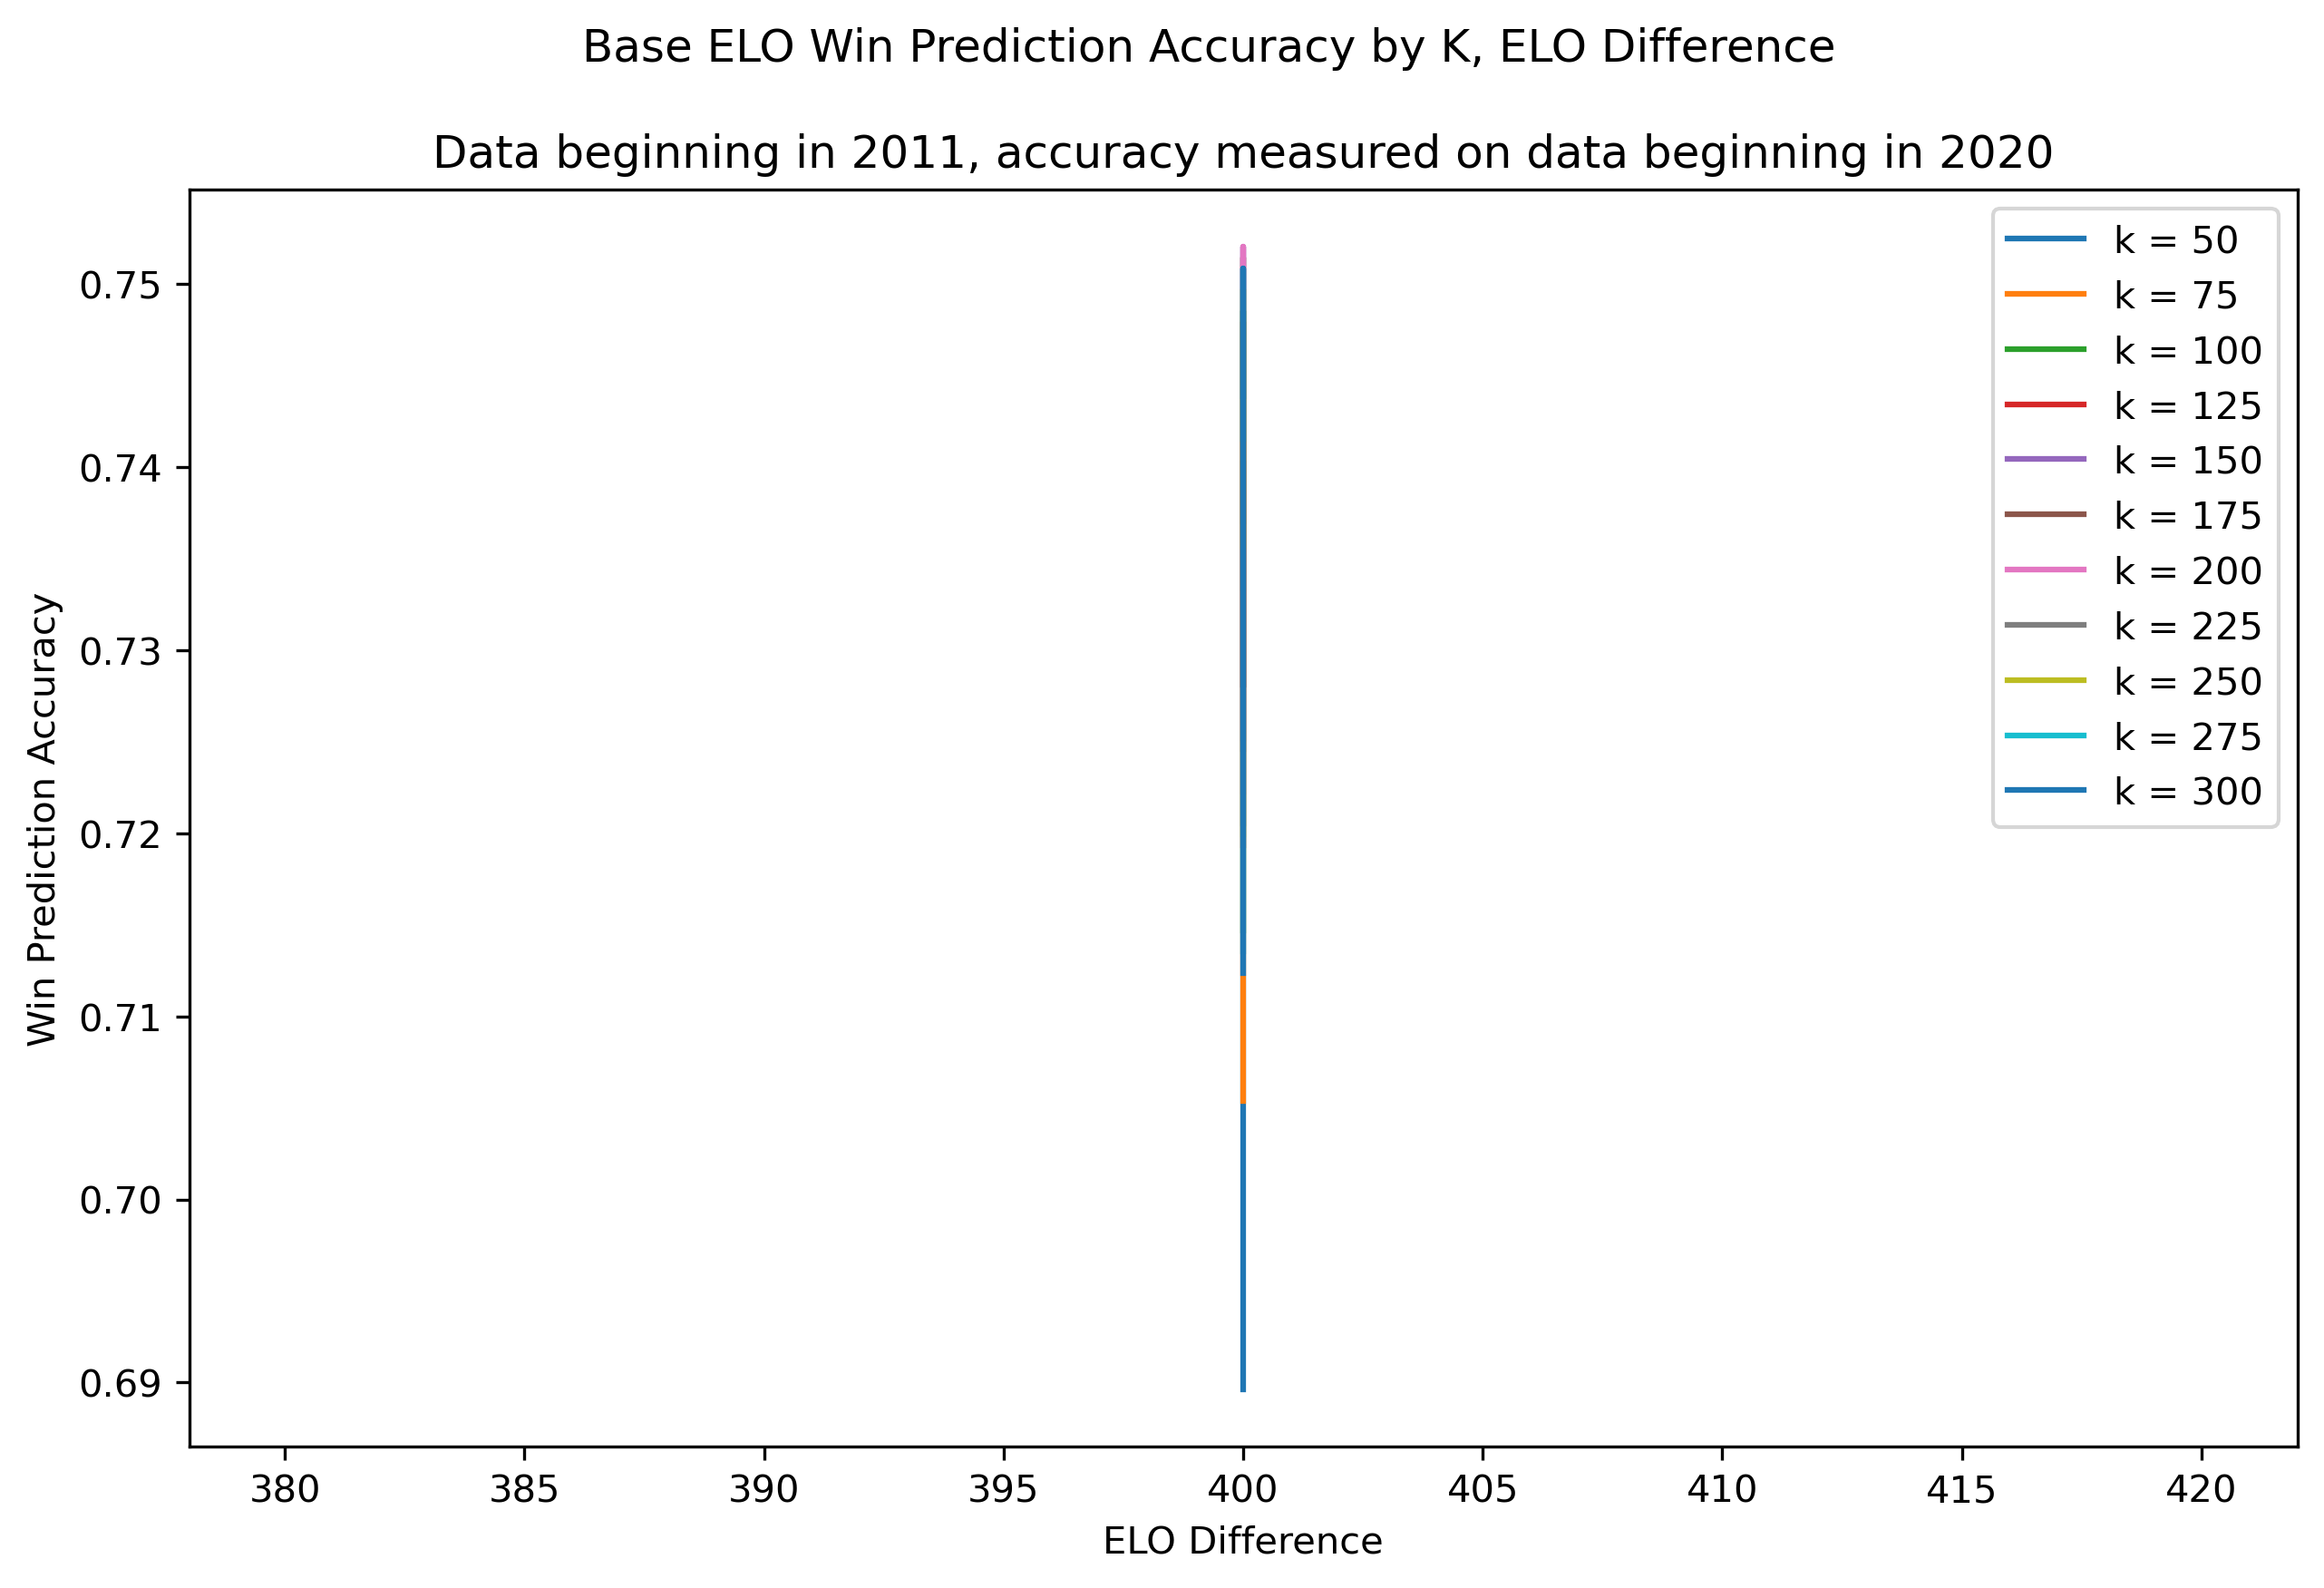

In [ ]:
import matplotlib.pyplot as plt


# Extract x, y, and z values from the accs dictionary
x = []
y = []
z = []
for key, value in accs.items():
    x.append(key[1])  # Use key[1] as x-axis
    y.append(value)  # Use value as y-axis
    z.append(key[0])  # Use key[0] as line identifier

plt.figure(dpi=300, figsize=(10, 6))
for line_id in sorted(list(set(z))):
    line_x = [x[i] for i in range(len(z)) if z[i] == line_id]
    line_y = [y[i] for i in range(len(z)) if z[i] == line_id]
    plt.plot(line_x, line_y, label=f"k = {line_id}")

# Set labels and title
plt.xlabel("ELO Difference")
plt.ylabel("Win Prediction Accuracy")
plt.suptitle("Base ELO Win Prediction Accuracy by K, ELO Difference")
plt.title("Data beginning in 2011, accuracy measured on data beginning in 2020")

# Add legend
plt.legend()

In [ ]:
school_dict = schools.to_dict()["school_name"]
df["winner_name"] = df.apply(lambda x: school_dict[x.winner], axis=1)
df["loser_name"] = df.apply(lambda x: school_dict[x.loser], axis=1)
df_prev = pd.concat([df.iloc[:, :3], df.iloc[:, 3:].shift()], axis=1)
df["winner_prev_elo"] = df_prev.apply(lambda x: x[x.winner], axis=1)
df["loser_prev_elo"] = df_prev.apply(lambda x: x[x.loser], axis=1)
# df['winner_win_prob'] = df.apply(lambda x: ELO.compute_expected_outcome_prob(x.winner_prev_elo, x.loser_prev_elo), axis=1)
# plt.figure(dpi=300, figsize=(5, 10))
# for team in nf.columns[3:]:
#     plt.plot(nf.timestamp, nf[team], label=team, alpha=0.5)